In [1]:
import os
import numpy as np

from keras import backend as K
from keras.models import load_model
from keras.layers import Input

from yolo_keras.utils import *
from yolo_keras.model import *

Using TensorFlow backend.


In [2]:
classes_path = "yolo_keras/coco_classes.txt"
with open(classes_path) as f:
    class_names = f.readlines()
    class_names = [c.strip() for c in class_names] 
num_classes = len(class_names)
print(class_names)

# Get the anchor box coordinates for the model
anchors_path = "yolo_keras/yolo_anchors.txt"
with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)
num_anchors = len(anchors)
print(anchors)

# Set the expected image size for the model
model_image_size = (416, 416)



['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
[[ 10.  13.]
 [ 16.  30.]
 [ 33.  23.]
 [ 30.  61.]
 [ 62.  45.]
 [ 59. 119.]
 [116.  90.]
 [156. 198.]
 [373. 326.]]


In [3]:
yolo_model = load_model("yolo.h5", compile=False)


input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(yolo_model.output, anchors, len(class_names), input_image_shape,
                                    score_threshold=0.3, iou_threshold=0.45)

print("YOLO model ready!")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
YOLO model ready!


In [4]:
def detect_objects(image):
    
    # normalize and reshape image data
    image_data = np.array(image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

    # Predict classes and locations using Tensorflow session
    sess = K.get_session()
    out_boxes, out_scores, out_classes = sess.run([boxes, scores, classes],
                feed_dict={yolo_model.input: image_data, input_image_shape: [image.size[1], image.size[0]],
                    K.learning_phase(): 0
                })
    return out_boxes, out_scores, out_classes

In [5]:
def show_objects(image, out_boxes, out_scores, out_classes):
    import random
    from PIL import Image
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt

    %matplotlib inline 
    
    # Set up some display formatting
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    # Plot the image
    img = np.array(image)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    # Set up padding for boxes
    img_size = model_image_size[0]
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    # Use a random color for each class
    unique_labels = np.unique(out_classes)
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)

    # process each instance of each class that was found
    for i, c in reversed(list(enumerate(out_classes))):

        # Get the class name
        predicted_class = class_names[c]
        # Get the box coordinate and probability score for this instance
        box = out_boxes[i]
        score = out_scores[i]

        # Format the label to be added to the image for this instance
        label = '{} {:.2f}'.format(predicted_class, score)

        # Get the box coordinates
        top, left, bottom, right = box
        y1 = max(0, np.floor(top + 0.5).astype('int32'))
        x1 = max(0, np.floor(left + 0.5).astype('int32'))
        y2 = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        x2 = min(image.size[0], np.floor(right + 0.5).astype('int32'))

        # Set the box dimensions
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        
        # Add a box with the color for this class
        color = bbox_colors[int(np.where(unique_labels == c)[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
        
    plt.axis('off')
    plt.show()

[[107.244125 134.63657  310.9469   396.91687 ]
 [ 92.938255   5.090969 320.5318   128.6219  ]]
---------------
[0.9981478  0.99706835]
---------------
[6 6]
Found 2 objects in 000863.jpg


<Figure size 432x288 with 0 Axes>

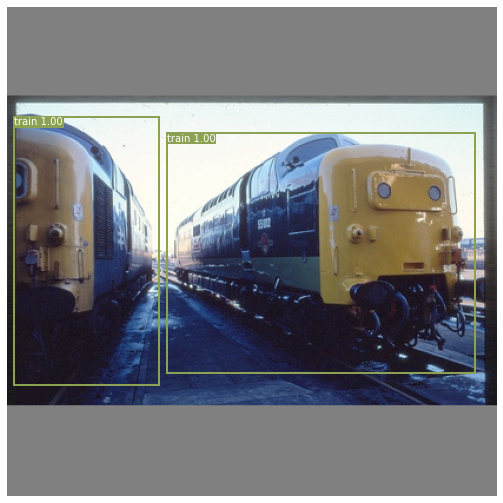

[[ 76.356224 131.25558   92.92402  166.3646  ]
 [ 87.7812   175.38005  106.119675 217.11511 ]
 [ 64.48807  182.30856   72.3392   196.29713 ]
 [ 97.18311  105.29506  123.85928  165.2785  ]
 [ 89.81064    5.006838 276.08182  363.00876 ]
 [ 97.63064  114.54857  123.57492  164.32234 ]]
---------------
[0.89421564 0.809208   0.43722332 0.40376282 0.9971268  0.4233498 ]
---------------
[2 2 2 2 6 7]
Found 6 objects in 005481.jpg


<Figure size 432x288 with 0 Axes>

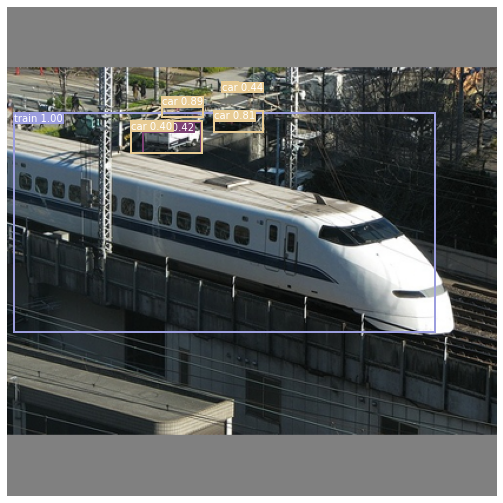

[[112.83264 198.24422 152.70685 221.04051]
 [171.87909 205.90302 206.375   232.27122]
 [195.62007 159.07152 279.83176 280.23672]
 [131.97092 179.044   185.06447 278.65186]
 [199.07762 190.90758 208.92036 204.16682]]
---------------
[0.9545757 0.6798776 0.9989047 0.977846  0.3566947]
---------------
[ 0  0  2  2 16]
Found 5 objects in 006011.jpg


<Figure size 432x288 with 0 Axes>

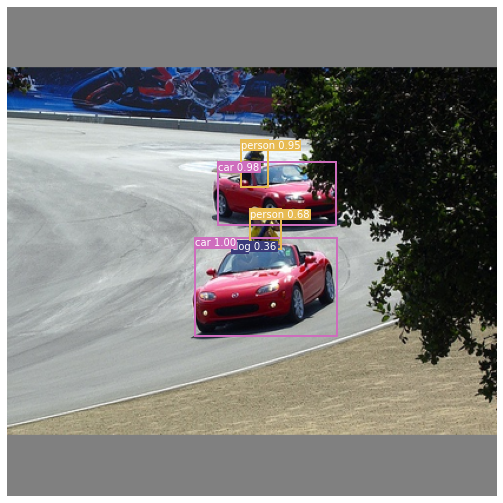

[[182.18976  161.18393  231.81169  243.16733 ]
 [170.00084  306.2035   205.06224  361.9144  ]
 [186.8511    24.791094 298.9082   163.04407 ]]
---------------
[0.9994318  0.99178594 0.99007946]
---------------
[2 2 2]
Found 3 objects in 006375.jpg


<Figure size 432x288 with 0 Axes>

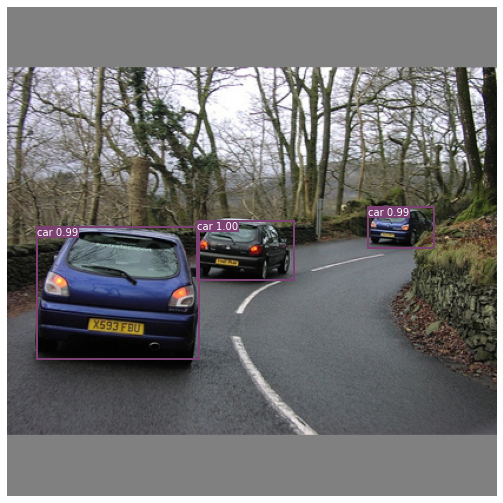

[[217.92223   82.74533  288.7474   123.93954 ]
 [222.71533  234.6613   237.03966  240.51532 ]
 [223.87271  241.14008  236.88724  247.06348 ]
 [219.81847    8.740685 236.144     16.990746]
 [252.20543   87.56229  315.4383   118.351234]
 [221.28595  262.71454  283.16736  388.53333 ]
 [214.47398   82.976715 224.28008   99.27582 ]
 [215.64929  133.70642  235.53918  163.68616 ]
 [212.56992   52.60975  220.81284   64.504265]
 [211.47372   38.802143 217.73648   46.592678]
 [209.56209   25.45176  214.95894   32.824913]]
---------------
[0.9842985  0.6775905  0.3770379  0.3238288  0.99556774 0.98597765
 0.95947546 0.9507053  0.9443181  0.67900217 0.35576206]
---------------
[0 0 0 0 1 2 2 2 2 2 2]
Found 11 objects in 007004.jpg


<Figure size 432x288 with 0 Axes>

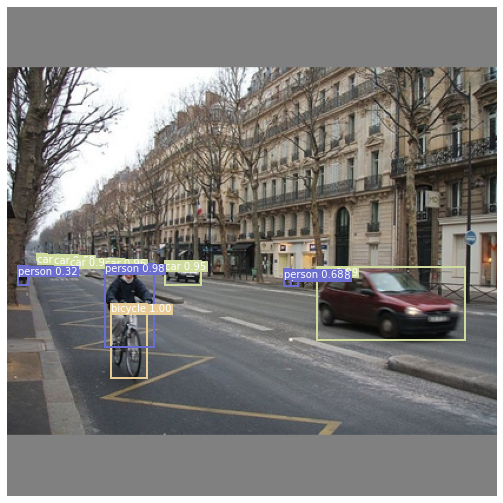

[[ 91.896225 134.5855   149.76497  190.57182 ]
 [195.47827   38.99954  244.75613   92.620674]
 [107.53221   22.792723 160.87442   79.141754]
 [187.21164  158.58432  237.84889  213.06122 ]
 [ 78.6772   329.4367   137.3106   384.34296 ]
 [269.8244    53.637447 316.3054   104.364296]]
---------------
[0.9998254  0.99965453 0.99923456 0.9991702  0.9978828  0.9967708 ]
---------------
[4 4 4 4 4 4]
Found 6 objects in 007152.jpg


<Figure size 432x288 with 0 Axes>

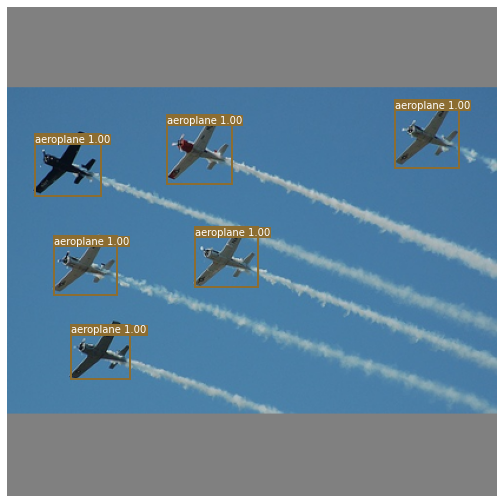

[[158.98726 175.19725 217.51422 280.3478 ]
 [168.53638 123.57239 242.0528  233.95343]]
---------------
[0.905412  0.8671101]
---------------
[4 4]
Found 2 objects in 007280.jpg


<Figure size 432x288 with 0 Axes>

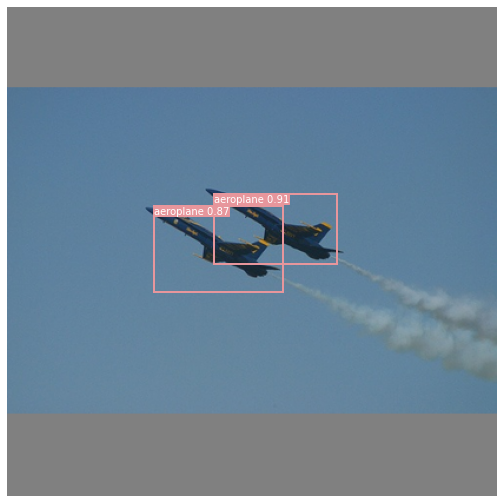

[[ 87.5507    132.0292    123.670715  192.19272  ]
 [179.8594    130.26006   261.0023    247.66206  ]
 [162.24153    -1.3777359 235.89534    82.3948   ]
 [114.42194    25.039986  158.03377    89.77618  ]
 [186.77765   355.18716   273.67743   416.41626  ]
 [120.041046  322.82678   165.06433   391.51968  ]
 [150.26045   345.46848   214.36082   417.05426  ]
 [150.68275    36.288383  208.25104   117.29344  ]
 [ 69.26688    14.144408   88.869385   43.715645 ]
 [ 69.352135   39.651337   78.66488    75.33671  ]
 [150.26045   345.46848   214.36082   417.05426  ]
 [168.54942   353.2466    273.12354   418.2712   ]]
---------------
[0.98823136 0.9857179  0.98070246 0.96453154 0.94742435 0.9355331
 0.8111547  0.7426665  0.46450448 0.44085166 0.40354028 0.39779836]
---------------
[2 2 2 2 2 2 2 2 2 2 7 7]
Found 12 objects in 009121.jpg


<Figure size 432x288 with 0 Axes>

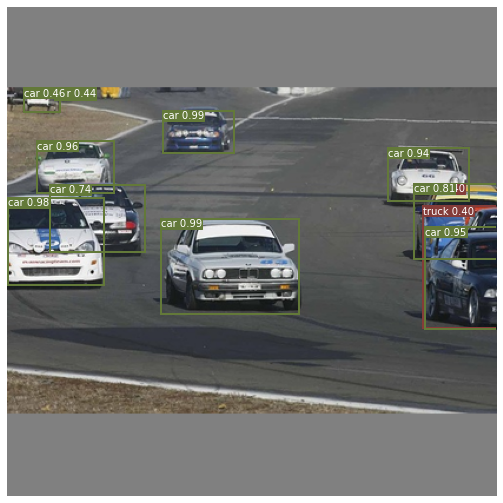

[[244.51791  273.1516   272.2892   348.55273 ]
 [249.2675   389.6585   266.65274  414.78    ]
 [249.0739   393.63     258.17728  415.86942 ]
 [129.40143   -8.124913 272.22244  280.09525 ]
 [244.51791  273.1516   272.2892   348.55273 ]]
---------------
[0.77492386 0.6792937  0.30338714 0.9998022  0.37972975]
---------------
[2 2 2 6 7]
Found 5 objects in 009254.jpg


<Figure size 432x288 with 0 Axes>

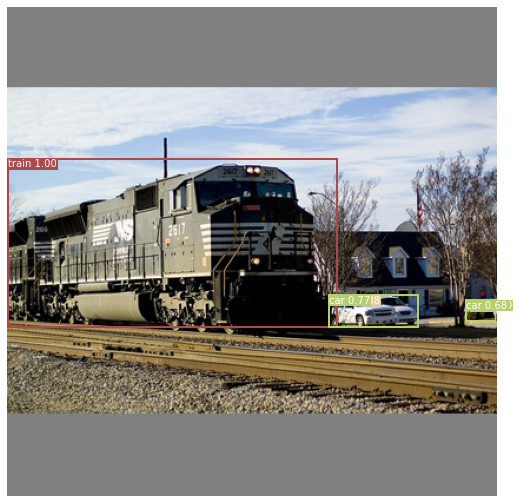

In [6]:
import os
from PIL import Image

# testing image directory 
test_dir = r"data/object_detection"
for image_file in os.listdir(test_dir):
    
    # Load image
    img_path = os.path.join(test_dir, image_file)
    image = Image.open(img_path)
    
    # Resize image for model input
    image = letterbox_image(image, tuple(reversed(model_image_size)))

    # Detect objects in the image
    out_boxes, out_scores, out_classes = detect_objects(image)
    print(out_boxes)
    print(15*"-")
    print(out_scores)
    print(15*"-")
    print(out_classes)
    # How many objects did we detect?
    print('Found {} objects in {}'.format(len(out_boxes), image_file))

    # Display the image with bounding boxes
    show_objects(image, out_boxes, out_scores, out_classes)

## With Own Image

In [17]:
def predict(image_path):
    # just give image path 
    img = Image.open(image_path)
#     print(img.size)
    image = letterbox_image(img, (416, 416))
#     print(image.size)
    
    box, score, classes = detect_objects(image)
    
    return show_objects(image, box, score, classes)

(500, 375)
(416, 416)
[[182.18976  161.18393  231.81169  243.16733 ]
 [170.00084  306.2035   205.06224  361.9144  ]
 [186.8511    24.791094 298.9082   163.04407 ]]
[0.9994318  0.99178594 0.99007946]
[2 2 2]


<Figure size 432x288 with 0 Axes>

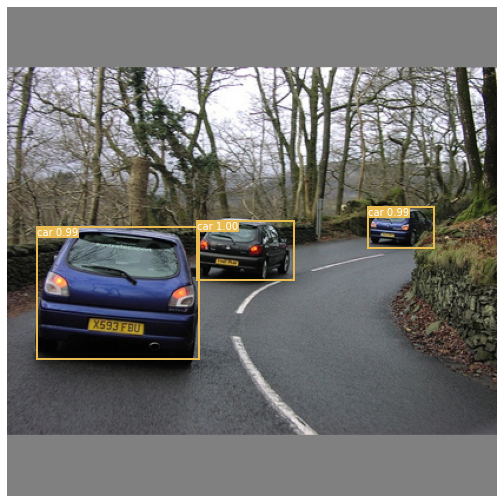

In [18]:
predict(r"F:\Computer Vision\Object Detection Yolov3\test1.jpg")